In [1]:
!pip install -q diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.2 MB/s eta 0:00:00


# Experimentation

Our approach 1 should be adding in some sort of guidance function that scales with ϵ during the diffusion loop (sampling/inference).

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch import autocast
from torchvision import transforms as tfms

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from matplotlib import pyplot as plt
import numpy as np

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

Epsilon is the conditioning parameter that we will try to teach the model to learn. Higher epsilon indicates more noise and how much more likely the classification model with predict incorrectly

## Define Classification Model

In [4]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2])
model.load_state_dict(torch.load("/content/resnet.ckpt"))
model.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### Test Classification Model

In [5]:
import requests
from PIL import Image
from io import BytesIO

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
init_image = download_image(img_url).resize((512, 512))

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
transform = tfms.Compose([
    tfms.Pad(4),
    tfms.RandomHorizontalFlip(),
    tfms.RandomCrop(32),
    tfms.ToTensor()])

test_input = transform(init_image)
test_input = torch.unsqueeze(test_input, dim=0)
test_input.shape

torch.Size([1, 3, 32, 32])

In [8]:
outputs = model(test_input)
_, predicted = torch.max(outputs, 1)
print(classes[predicted[0]])
print(torch.unsqueeze(predicted[0], dim=0).cpu())
# print(predicted[0])

cat
tensor([3])


In [18]:
torch.unsqueeze(torch.argmax(outputs, 1), dim=0).shape

torch.Size([1, 1])

## Stable Diffusion Sampling

In [22]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from torchvision import transforms as tfms

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base" # @param

In [61]:
class Attack:
  def __init__(self, model_id, classifer):
    self.pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

    # Set up a generator for reproducibility
    self.generator = torch.Generator(device=device).manual_seed(42)

    self.classifer = classifer

  def __call__(self, prompt, negative_prompt="", guidance_scale=8, epsilon=0):
    # Run the pipeline, showing some of the available arguments
    pipe_output = self.pipe(
        prompt=prompt, # What to generate
        negative_prompt=negative_prompt, # What NOT to generate
        height=480, width=640,     # Specify the image size
        guidance_scale=guidance_scale,          # How strongly to follow the prompt
        num_inference_steps=30,    # How many steps to take
        generator=self.generator        # Fixed random seed
    )

    # Resulting image:
    init_image = pipe_output.images[0]
    image = self.transform(init_image)
    image = torch.unsqueeze(image, dim=0)

    image.requires_grad = True

    outputs = self.classifer(image).to(device)
    
    target = torch.tensor([0]).to(device)

    return (init_image, self.untargeted_attack(image, outputs, target, epsilon))


  def transform(self, image):
    transform = tfms.Compose([
        tfms.Resize(32),
        tfms.ToTensor()
    ])

    return transform(image)

  def untargeted_attack(self, image, pred, target, epsilon):
    loss = torch.nn.functional.nll_loss(pred, target)

    self.classifer.zero_grad()

    loss.backward()
    
    gradient_sign = image.grad.data.sign()
    perturbed_image = image + epsilon*gradient_sign
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
 
    return perturbed_image

In [59]:
attack = Attack(model_id, model)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [60]:
prompt = "A deer in a virtual reality world"
image, perturbed_image = attack(prompt, epsilon=0.15)

  0%|          | 0/30 [00:00<?, ?it/s]

tensor([[[[ 1., -1., -1.,  ...,  1., -1.,  1.],
          [-1.,  1.,  1.,  ...,  1., -1., -1.],
          [-1., -1., -1.,  ..., -1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ..., -1.,  1., -1.],
          [ 1.,  1.,  1.,  ...,  1., -1., -1.],
          [-1., -1.,  1.,  ..., -1.,  1.,  1.]],

         [[ 1., -1., -1.,  ...,  1., -1.,  1.],
          [-1.,  1.,  1.,  ..., -1., -1.,  1.],
          [-1.,  1.,  1.,  ..., -1.,  1.,  1.],
          ...,
          [-1., -1., -1.,  ..., -1.,  1., -1.],
          [ 1.,  1.,  1.,  ...,  1., -1., -1.],
          [ 1., -1.,  1.,  ..., -1.,  1., -1.]],

         [[ 1., -1., -1.,  ...,  1., -1.,  1.],
          [-1.,  1., -1.,  ...,  1., -1., -1.],
          [ 1., -1.,  1.,  ..., -1.,  1.,  1.],
          ...,
          [-1.,  1.,  1.,  ..., -1.,  1., -1.],
          [-1., -1.,  1.,  ...,  1., -1.,  1.],
          [ 1., -1.,  1.,  ..., -1.,  1., -1.]]]])
tensor([[[[ 0.2245, -0.0363,  0.0657,  ...,  1.0441,  0.6108,  0.9461],
          [-

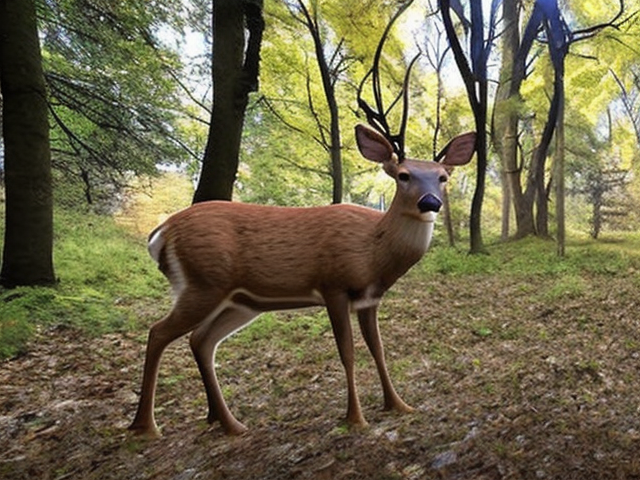

In [62]:
image

In [63]:
perturbed_image.shape

torch.Size([1, 3, 32, 42])

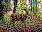

In [64]:
import torchvision.transforms as T
from PIL import Image

transform = T.ToPILImage()
img = transform(perturbed_image[0])
img

In [57]:
# free CUDA GPU Memory
del attack
torch.cuda.empty_cache()

In [67]:
transform = tfms.Compose([
    tfms.Resize(32),
    tfms.ToTensor()])

test_input = transform(img)
test_input = torch.unsqueeze(test_input, dim=0)

outputs = model(test_input)
_, predicted = torch.max(outputs, 1)
print(classes[predicted[0]])
print(torch.unsqueeze(predicted[0], dim=0).cpu())

frog
tensor([6])


## View CIFAR10 Data

In [ ]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=tfms.Compose([
        tfms.ToTensor(),
        tfms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])),
        batch_size=1, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


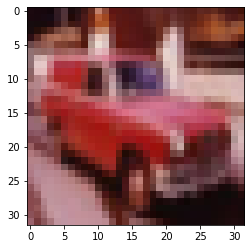

car


In [ ]:
images, labels = next(iter(test_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(classes[labels[0]])

In [ ]:
labels

tensor([1])

## Loading Models

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.13.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.mlp.fc2.bias', 'vision_model.encoder.layers.15.layer_norm2.bias', 'vision_model.encoder.layers.20.layer_norm2.bias', 'vision_model.encoder.layers.17.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.bias', 'vision_model.encoder.layers.9.layer_norm2.weight', 'vision_model.encoder.layers.18.layer_norm2.weight', 'vision_model.encoder.layers.19.self_attn.k_proj.weight', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.8.layer_norm1.bias', 'vision_model.encoder.layers.13.mlp.fc1.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.bias', 'vision_model.encoder.lay

## Diffusion Sampling Loop

In [ ]:
# Some settings
prompt = "A dog in space" # @param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # @param Number of denoising steps
guidance_scale = 7.5                # @param Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1                      # @param
epsilon = 0.15                         # @param amount of perturbations

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

# Unconditioned input
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

# Combining conditioned and unconditioned
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        if i%5 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            # latents_x0 = latents - sigma * noise_pred
            latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

            # Calculate loss
            loss = attack_loss(model, transform(denoised_images), epsilon)

            break
            
            # Occasionally print it out
            if i%10==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

0it [00:00, ?it/s]

TypeError: ignored